In [ ]:
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder, label, image_size=(32, 32)):
    images = []
    labels = []

    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            img = Image.open(path).convert('RGB').resize(image_size)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load Bears (label 0) and Pandas (label 1)
beagle_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/beagle"
bulldog_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/bulldog"
dalmatian_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/dalmatian"
german_shepherd_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/german-shepherd"
husky_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/husky"
poodle_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/poodle"
rottweiler_folder = r"/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/rottweiler"


In [ ]:
beagle_images, beagle_labels = load_images_from_folder(beagle_folder, label=0)
bulldog_images, bulldog_labels = load_images_from_folder(bulldog_folder, label=1)
dalmatian_images, dalmatian_labels = load_images_from_folder(dalmatian_folder, label=2)
german_shepherd_images, german_shepherd_labels = load_images_from_folder(german_shepherd_folder, label=3)
husky_images, husky_labels = load_images_from_folder(husky_folder, label=4)
poodle_images, poodle_labels = load_images_from_folder(poodle_folder, label=5)
rottweiler_images, rottweiler_labels = load_images_from_folder(rottweiler_folder, label=6)


In [ ]:
# Combine them
data= np.concatenate((beagle_images, bulldog_images,dalmatian_images,german_shepherd_images,husky_images,poodle_images,rottweiler_images), axis=0)
labels = np.concatenate((beagle_labels, bulldog_labels,dalmatian_labels,german_shepherd_labels,husky_labels,poodle_labels,rottweiler_labels), axis=0)

In [ ]:
data.shape

(490, 32, 32, 3)

In [ ]:
len(labels)

490

In [ ]:
label_names = [
    "beagle", "bulldog", "dalmatian",
    "german_shepherd", "husky", "poodle", "rottweiler"
]


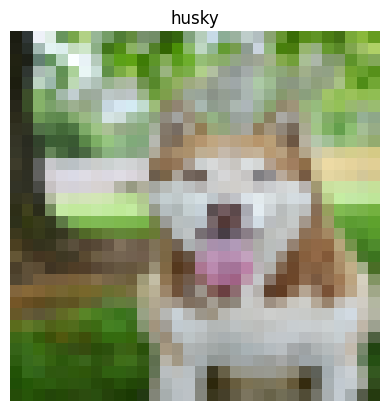

In [ ]:
import matplotlib.pyplot as plt

img = data[300]
plt.imshow(img)
plt.title(label_names[labels[300]])
plt.axis('off')
plt.show()


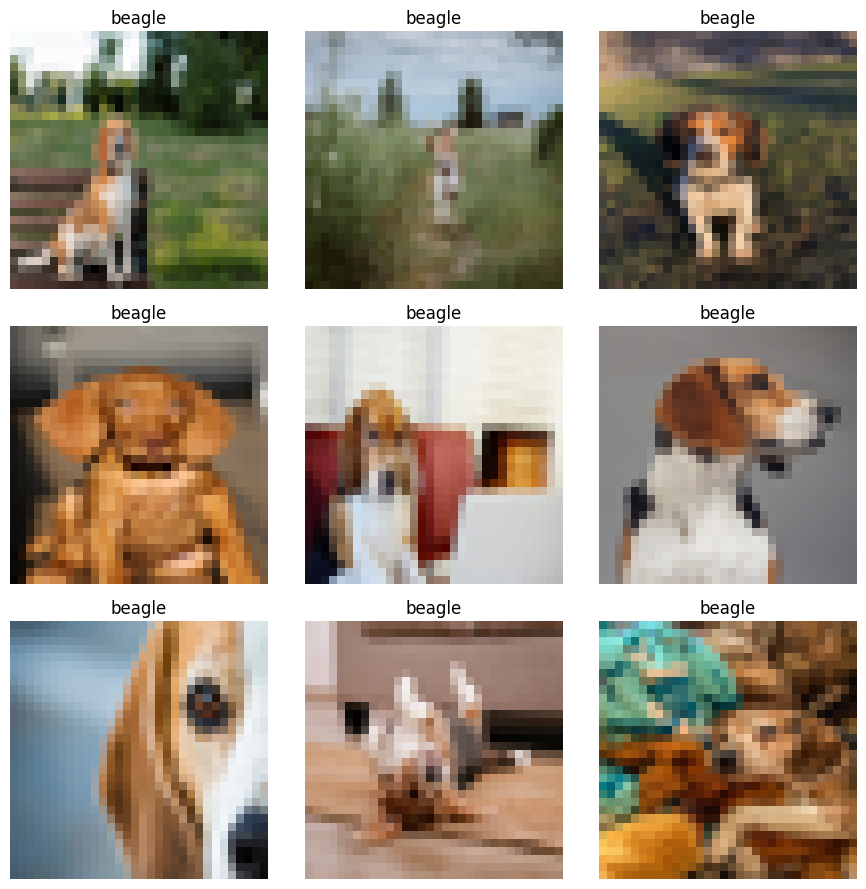

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3x3 grid, adjust the size as needed

for i, ax in enumerate(axes.flat):  # Flattening the axes array for easy iteration
    if i < 9:  # Ensure there are at least 9 images
        img = data[i]
        ax.imshow(img)
        ax.set_title(label_names[labels[i]])
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off axes for any extra subplots

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # Shape: (32, 32, 3)
        img = Image.fromarray(img)  # Convert to PIL Image

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]


In [ ]:
import torch
from torch.utils.data import DataLoader
import timm
import torch.nn as nn
from torchvision import transforms
import tqdm
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, len(label_names))  # classification
model = model.to(device)  # Move model to device

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Transformation to resize images to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])


In [ ]:
# Define your custom dataset here (as discussed before)
dataset = CustomDataset(data=data, labels=labels, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 5  # You can increase this for better accuracy

In [ ]:

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    print(f"🔁 Starting epoch {epoch + 1}/{epochs}")

    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}", total=len(train_loader))

    for batch_idx, (images, targets) in enumerate(progress_bar):
        try:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        except Exception as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            continue

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch [{epoch + 1}/{epochs}] Avg Loss: {avg_loss:.4f}")


🔁 Starting epoch 1/5


Epoch 1: 100%|██████████| 16/16 [16:37<00:00, 62.34s/it, loss=0.0599]


✅ Epoch [1/5] Avg Loss: 0.9326
🔁 Starting epoch 2/5


Epoch 2: 100%|██████████| 16/16 [16:33<00:00, 62.11s/it, loss=0.00169]


✅ Epoch [2/5] Avg Loss: 0.0461
🔁 Starting epoch 3/5


Epoch 3: 100%|██████████| 16/16 [16:18<00:00, 61.17s/it, loss=0.00177]


✅ Epoch [3/5] Avg Loss: 0.0080
🔁 Starting epoch 4/5


Epoch 4: 100%|██████████| 16/16 [16:25<00:00, 61.61s/it, loss=9.8e-5]


✅ Epoch [4/5] Avg Loss: 0.0012
🔁 Starting epoch 5/5


Epoch 5: 100%|██████████| 16/16 [16:24<00:00, 61.53s/it, loss=0.000641]

✅ Epoch [5/5] Avg Loss: 0.0004


In [ ]:
model_path = "/content/drive/MyDrive/machin/vit_dog_breed.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to /content/drive/MyDrive/machin/vit_dog_breed.pth


In [ ]:
model_path = "/content/drive/MyDrive/machin/vit_dog_breed.pth"

In [ ]:
def predict_image(model, image_path, transform, label_names=["beagle", "bulldog", "dalmatian",
    "german_shepherd", "husky", "poodle", "rottweiler"]):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred_class = torch.argmax(output, dim=1).item()

    return label_names[pred_class]


In [ ]:
image_path = "/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/husky/husky10.jpg"  # Change this path
predicted_label = predict_image(model, image_path, transform)
print(f"🔍 Predicted label: {predicted_label}")

🔍 Predicted label: husky


In [ ]:
import matplotlib.pyplot as plt

def show_prediction(image_path, model, transform, label_names=["beagle", "bulldog", "dalmatian",
    "german_shepherd", "husky", "poodle", "rottweiler"]):
    # Load and transform image
    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = label_names[pred_class]

    # Show image
    plt.imshow(img_pil)
    plt.title(f"Predicted: {pred_label}", fontsize=16)
    plt.axis('off')
    plt.show()


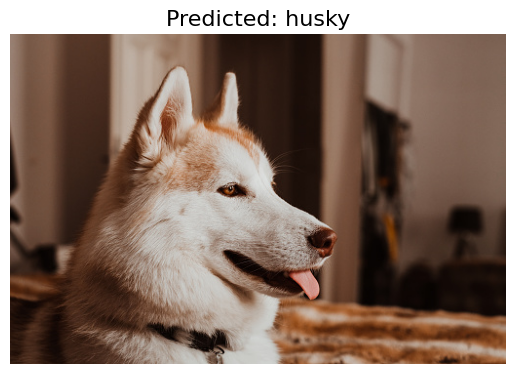

In [ ]:
image_path = "/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/husky/husky10.jpg"  # Change this path
show_prediction(image_path, model, transform)


Enter the image path/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/dalmatian/dalmatian18.jpg


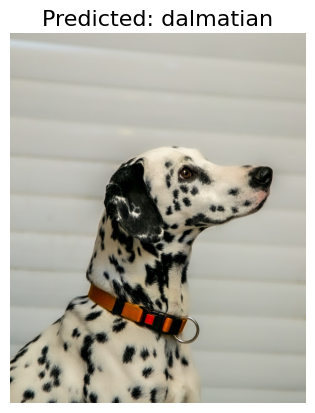

In [ ]:
image_path = str(input("Enter the image path"))  # example path
show_prediction(image_path, model, transform)


In [ ]:
import torch.nn.functional as F

def show_topk_predictions(image_path, model, transform, label_names=["beagle", "bulldog", "dalmatian",
    "german_shepherd", "husky", "poodle", "rottweiler"], topk=2):
    # Load and transform image
    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probs, k=topk)

    # Convert to CPU for display
    top_probs = top_probs[0].cpu().numpy()
    top_idxs = top_idxs[0].cpu().numpy()

    # Build prediction strings
    predictions = [
        f"{label_names[idx]}: {prob * 100:.2f}%" for idx, prob in zip(top_idxs, top_probs)
    ]
    prediction_text = "\n".join(predictions)

    # Show image with predictions
    plt.imshow(img_pil)
    plt.title(f"Top-{topk} Predictions:\n{prediction_text}", fontsize=12)
    plt.axis('off')
    plt.show()


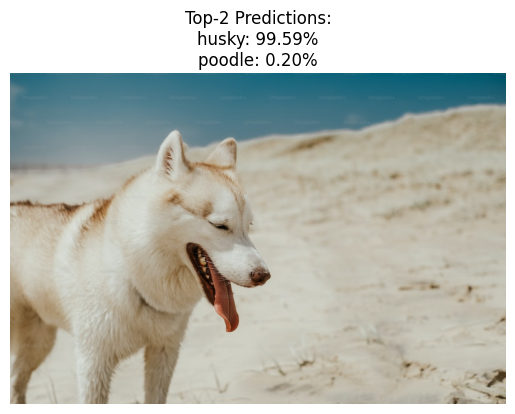

In [ ]:
image_path = "/content/drive/MyDrive/Transfer learning/Cat and dog/dog breed/dog-breeds/train/husky/husky34.jpg"  # Change this path
show_topk_predictions(image_path, model, transform)
